In [1]:
import os

import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import json

def parse_sarcasm_json_dataset(file):
    for line in open(file, 'r'):
        yield json.loads(line)

In [3]:
data = list(parse_sarcasm_json_dataset('../data/news_headlines_for_sarcasm_detection/Sarcasm_Headlines_Dataset_v2.json'))

df = pd.DataFrame(data)
df

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...
...,...,...,...
28614,1,jews to celebrate rosh hashasha or something,https://www.theonion.com/jews-to-celebrate-ros...
28615,1,internal affairs investigator disappointed con...,https://local.theonion.com/internal-affairs-in...
28616,0,the most beautiful acceptance speech this week...,https://www.huffingtonpost.com/entry/andrew-ah...
28617,1,mars probe destroyed by orbiting spielberg-gat...,https://www.theonion.com/mars-probe-destroyed-...


In [4]:
df = df.drop(columns=['article_link'])
df

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...
...,...,...
28614,1,jews to celebrate rosh hashasha or something
28615,1,internal affairs investigator disappointed con...
28616,0,the most beautiful acceptance speech this week...
28617,1,mars probe destroyed by orbiting spielberg-gat...


In [5]:
# It is only fine-tuning, thus 400k data samples is a complete overkill. It can be reduced to 40k.
df = df.iloc[:10000]

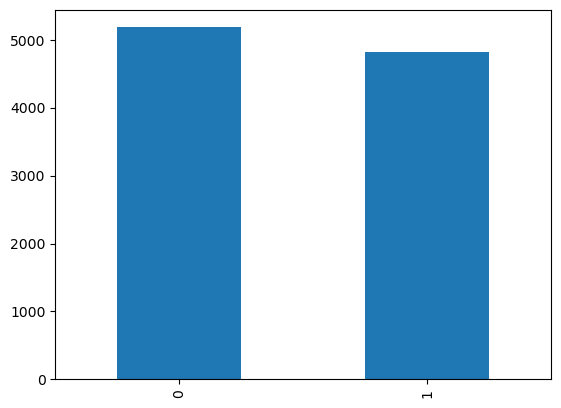

In [6]:
data = df["is_sarcastic"]
data.value_counts().plot.bar()
plt.show()

In [7]:
from datasets import Dataset

raw_dataset = Dataset.from_pandas(df)
raw_dataset

Dataset({
    features: ['is_sarcastic', 'headline'],
    num_rows: 10000
})

In [8]:
from transformers import AutoTokenizer

checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [9]:
def tokenize_function(example):
    return tokenizer(example["headline"], truncation=True)


tokenized_dataset = raw_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [10]:
# Train set: 80%, Validation set: 10%, Test set: 10%
split_train_val_and_test_dataset = tokenized_dataset.train_test_split(train_size=0.8)
split_val_test_dataset = split_train_val_and_test_dataset["test"].train_test_split(test_size=0.5)

tokenized_train_dataset = split_train_val_and_test_dataset["train"]
tokenized_val_dataset = split_val_test_dataset["train"]
tokenized_test_dataset = split_val_test_dataset["test"]

In [11]:
from transformers import DataCollatorWithPadding

batch_size = 16


def convert_to_tf_dataset(hf_dataset, collator, batch_size=batch_size, shuffle=True):
    return hf_dataset.to_tf_dataset(
        columns=["attention_mask", "input_ids", "token_type_ids"],
        label_cols=["is_sarcastic"],
        collate_fn=collator,
        shuffle=shuffle,
        batch_size=batch_size,
    )


data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

tf_train_dataset = convert_to_tf_dataset(hf_dataset=tokenized_train_dataset, collator=data_collator)
tf_val_dataset = convert_to_tf_dataset(hf_dataset=tokenized_val_dataset, collator=data_collator)
tf_test_dataset = convert_to_tf_dataset(hf_dataset=tokenized_test_dataset, collator=data_collator)

C:\Users\Karol\anaconda3\envs\ml-tf2gpu\lib\site-packages\datasets\arrow_dataset.py:388: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [12]:
import Constants

# Callbacks
training_number = 1
model_name = "sarcasm_eng_bert"
training_folder = f"training_{training_number}"
checkpoint_filename = "cp-{epoch:04d}.ckpt"
training_path = os.path.join(Constants.TRAINING_CHECKPOINTS_PATH, model_name, training_folder)
checkpoint_path = os.path.join(training_path, checkpoint_filename)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, verbose=1, save_weights_only=True)

early_stop_cb = tf.keras.callbacks.EarlyStopping(patience=3)

In [13]:
checkpoint_path

'../training_checkpoints\\sarcasm_eng_bert\\training_1\\cp-{epoch:04d}.ckpt'

In [14]:
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.optimizers import Adam

num_epochs = 10
# The number of training steps is the number of samples in the dataset, divided by the batch size then multiplied
# by the total number of epochs. Note that the tf_train_dataset here is a batched tf.data.Dataset,
# not the original Hugging Face Dataset, so its len() is already num_samples // batch_size.
num_train_steps = len(tf_train_dataset) * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps
)

optimizer = Adam(learning_rate=lr_scheduler)

In [15]:
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
# Compile
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ["accuracy"]
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [17]:
history = model.fit(tf_train_dataset, validation_data=tf_val_dataset, epochs=num_epochs, callbacks=[checkpoint_cb, early_stop_cb])

Epoch 1/10
500/500 [==============================] - 49s 73ms/step - loss: 0.3275 - accuracy: 0.8597 - val_loss: 0.2647 - val_accuracy: 0.8780

Epoch 00001: saving model to ../training_checkpoints\sarcasm_eng_bert\training_1\cp-0001.ckpt
Epoch 2/10
500/500 [==============================] - 34s 69ms/step - loss: 0.1203 - accuracy: 0.9571 - val_loss: 0.2818 - val_accuracy: 0.8910

Epoch 00002: saving model to ../training_checkpoints\sarcasm_eng_bert\training_1\cp-0002.ckpt
Epoch 3/10
500/500 [==============================] - 34s 69ms/step - loss: 0.0481 - accuracy: 0.9833 - val_loss: 0.3336 - val_accuracy: 0.9170

Epoch 00003: saving model to ../training_checkpoints\sarcasm_eng_bert\training_1\cp-0003.ckpt
Epoch 4/10
500/500 [==============================] - 36s 71ms/step - loss: 0.0161 - accuracy: 0.9945 - val_loss: 0.4417 - val_accuracy: 0.9030

Epoch 00004: saving model to ../training_checkpoints\sarcasm_eng_bert\training_1\cp-0004.ckpt


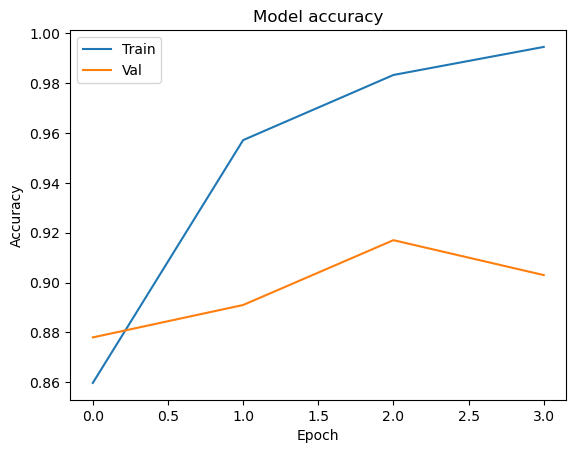

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig(f"../documentation/models/{model_name}/figures/{training_folder}_accuracy.png")
plt.show()

In [19]:
import shutil

best_model_checkpoint_index = np.argmin(history.history["val_accuracy"]) + 1
best_model_weights_path = os.path.join(training_path, checkpoint_filename.format(epoch=best_model_checkpoint_index))
best_model = model
best_model.load_weights(best_model_weights_path)

shutil.rmtree(training_path)

In [20]:
saved_model_name = f"{model_name}_{training_number}"

# Save to Saved Model format
best_model.save(os.path.join(Constants.SAVED_MODEL_LOCATION, saved_model_name, Constants.DEFAULT_MODEL_VERSION))

INFO:tensorflow:Assets written to: ../trained_models\sarcasm_eng_bert_1\1\assets


INFO:tensorflow:Assets written to: ../trained_models\sarcasm_eng_bert_1\1\assets


In [21]:
# Evaluation
best_model.evaluate(tf_test_dataset, batch_size=32)

63/63 [==============================] - 2s 29ms/step - loss: 0.2503 - accuracy: 0.8860


[0.25032681226730347, 0.8859999775886536]

In [22]:
tokenized_train_dataset[0]

{'is_sarcastic': 0,
 'headline': 'imf chief lagarde found guilty in french tycoon payout trial',
 'input_ids': [101,
  10047,
  2546,
  2708,
  2474,
  13444,
  2063,
  2179,
  5905,
  1999,
  2413,
  5939,
  3597,
  2239,
  3477,
  5833,
  3979,
  102],
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [25]:
prediction_logits = best_model.predict(tf_train_dataset)['logits']

In [26]:
prediction_logits[0]

array([ 2.209996 , -2.6576033], dtype=float32)